# Description of the project :

In this project, I am investigating the estimation and correction of Carrier Frequency Offset (CFO) in an OFDM (Orthogonal Frequency Division Multiplexing) communication system using experimental data measured using Pi Radio. CFO is a critical impairment in wireless systems, arising from oscillator mismatches between the transmitter and receiver, and it can significantly degrade system performance by destroying subcarrier orthogonality. The primary objective of this work is to develop, implement, and analyze robust CFO estimation and correction algorithms, and to understand their behavior under real experimental conditions.


For every experiment, we continuously transmit the same OFDM signal, consisting of 1024 OFDM symbols (4QAM), over the air. Of these, only 520 subcarriers are active and carry data symbols in each OFDM symbol, while the remaining subcarriers serve as guard bands or DC (unused) carriers. At the receiver, we capture 256 consecutive frames for analysis. The system operates at a carrier frequency of
Fc=10GHz (FR3 Band) with a sampling frequency of fs=983.04MHz. To study the impact of frequency mismatch, we deliberately introduce a fixed carrier frequency offset (CFO) for all transmitted symbols. The CFO is varied across experiments within the range of −40 to +40 parts per million (ppm), where 0 ppm corresponds to perfect frequency alignment (no CFO error).

# First Case : Without Frequency Offset ( CFO =0 ppm)

In [38]:
import numpy as np
import matplotlib.pyplot as plt
# Load the .npz file
data = np.load('10.0GHz_0ppm.npz')

In [41]:
txtd= np.array(data['txtd'])
rxtd=np.array(data['rxtd_10.0'])
print("txtd shape:", txtd.shape)
print("rxtd shape:", rxtd.shape)

txtd shape: (1, 2, 1024)
rxtd shape: (256, 2, 1024)


The file '10.0GHz_0ppm.npz' contains two primary data arrays. In this experiment, transmission is performed using two transmit antennas and reception is captured with two receive antennas. The first array, txtd, stores the transmitted data for 1024 OFDM symbols per antenna, of which only 520 subcarriers are actively used for data transmission. The second array, rxtd, contains the received symbols, corresponding to 256 captured frames at the receiver side.

In [43]:
num_frames_rx = rxtd.shape[0]
num_antennas_rx = rxtd.shape[1]
frame_length = rxtd.shape[2] # Should be 1024

num_antennas_tx = txtd.shape[1]
# We will use the first antenna of the transmitted signal as our reference for synchronization
# If txtd_time_original has only one frame, we take it directly.
ref_signal_time = txtd[0, 0, :] # Reference signal from TX, Antenna 0

##Frames Synchronization :
The first step in processing the received frames is synchronization, as the exact capture timing of each frame at the receiver is initially unknown. Synchronization aligns the received data frames with the transmitted signal, ensuring that subsequent processing-such as FFT, CFO estimation, and equalization-is performed on correctly aligned OFDM symbols.  Synchronization is therefore essential for accurate channel estimation and overall system performance.

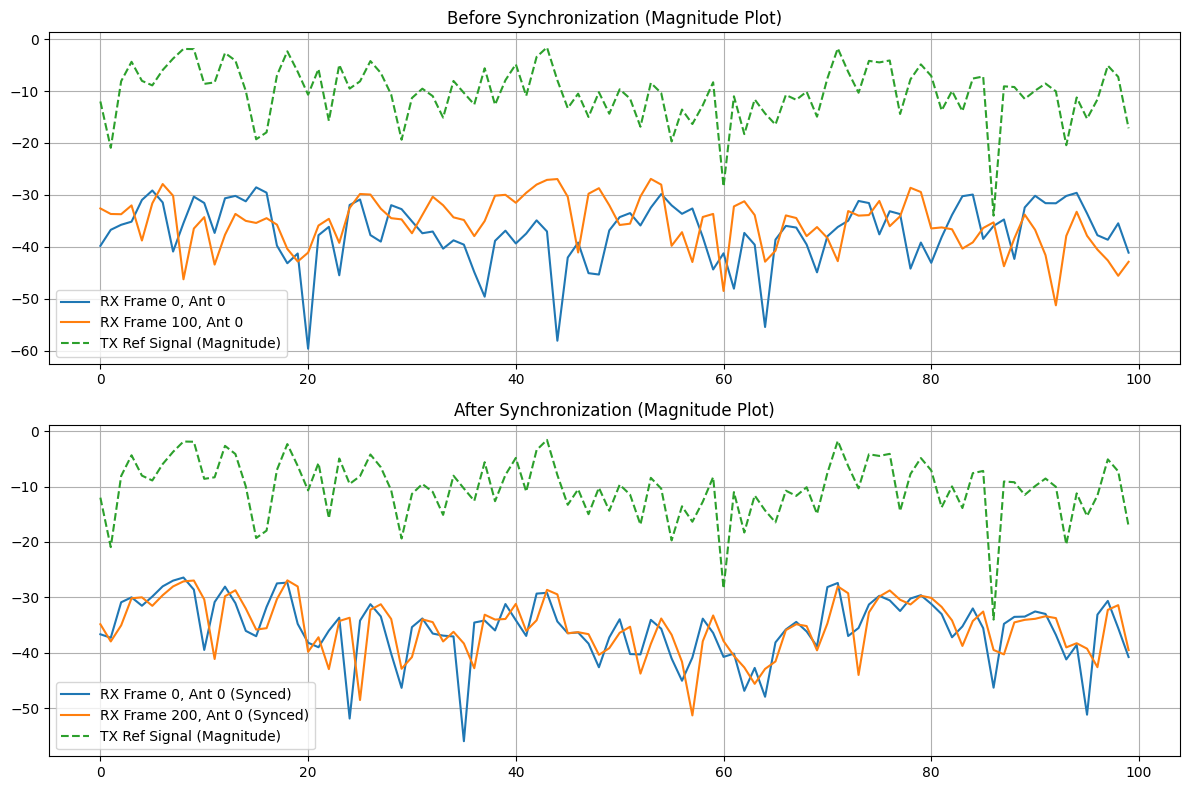

In [45]:
# --- Step 2: Time Synchronization of Received Frames ---

def synchronize_frames_with_tx_ref(rxtd_frames, reference_signal):
    """
    Synchronizes each frame in rxtd_frames by correlating it with the reference_signal.
    Args:
        rxtd_frames (np.array): Received frames, shape (num_frames, num_antennas, frame_length).
        reference_signal (np.array): The reference time-domain signal, shape (frame_length,).
    Returns:
        np.array: Synchronized received frames.
    """
    n_frames = rxtd_frames.shape[0]
    n_antennas = rxtd_frames.shape[1]
    n_samples = rxtd_frames.shape[2]

    synchronized_rxtd = np.zeros_like(rxtd_frames, dtype=complex)

    ant_idx=0
    for frame_idx in range(n_frames):
          rx_signal_segment = rxtd_frames[frame_idx, ant_idx, :]

          correlation = np.abs(np.correlate(rx_signal_segment, reference_signal, mode='full'))
          delay_index = np.argmax(correlation)
          shift_amount = delay_index - (len(reference_signal) - 1)
          synchronized_rxtd[frame_idx, ant_idx, :] = np.roll(rx_signal_segment, -shift_amount)

    return synchronized_rxtd

rxtd_time_synced = synchronize_frames_with_tx_ref(rxtd, ref_signal_time)


antenna_to_plot = 0

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(20*np.log10(np.abs(rxtd[0, antenna_to_plot, 0:100])), label=f'RX Frame {0}, Ant {antenna_to_plot} ')
plt.plot(20*np.log10(np.abs(rxtd[100, antenna_to_plot, 0:100])), label=f'RX Frame {100}, Ant {antenna_to_plot}')
plt.plot(20*np.log10(np.abs(ref_signal_time[0:100])), label='TX Ref Signal (Magnitude)', linestyle='--')
plt.title('Before Synchronization (Magnitude Plot)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(20*np.log10(np.abs(rxtd_time_synced[0, antenna_to_plot, 0:100])), label=f'RX Frame {0}, Ant {antenna_to_plot} (Synced)')
plt.plot(20*np.log10(np.abs(rxtd_time_synced[100, antenna_to_plot, 0:100])), label=f'RX Frame {200}, Ant {antenna_to_plot} (Synced)')
plt.plot(20*np.log10(np.abs(ref_signal_time[0:100])), label='TX Ref Signal (Magnitude)', linestyle='--')
plt.title('After Synchronization (Magnitude Plot)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##Fequency Shifting:

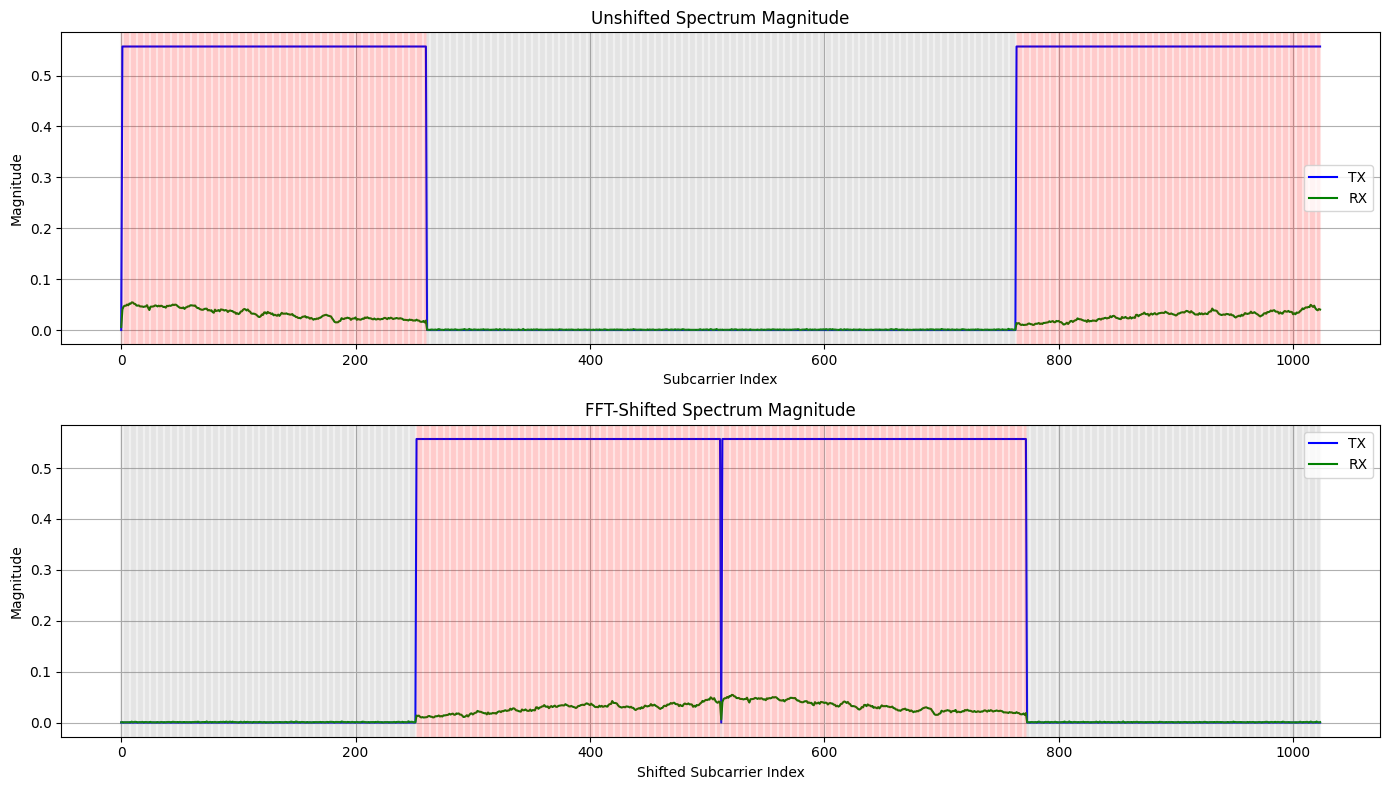

In [48]:
def frequency_shifting(rxtd_time_synced,txtd, N):
  active_indices = np.concatenate([np.arange(1, 261), np.arange(764, 1024)])
  # Compute the FFT-shifted indices for plotting the shifted spectrum
  active_indices_shifted = (active_indices + N//2) % N
  full_indices = np.arange(N)
  tx_unshifted = np.fft.fft(txtd[0, 0, :]) / np.sqrt(N)
  tx_shifted   = np.fft.fftshift(tx_unshifted)


  rx_unshifted=np.zeros(rxtd.shape,dtype = 'complex')
  rx_shifted=np.zeros(rxtd.shape,dtype = 'complex')
  # FFT and FFT shift for TX (antenna 0)
  ant_idx=0
  for frame_idx in range(256):
          rx_unshifted[frame_idx, ant_idx, :] = np.fft.fft(rxtd_time_synced[frame_idx, ant_idx, :]) / np.sqrt(N)
          rx_shifted[frame_idx, ant_idx, :]  = np.fft.fftshift(rx_unshifted[frame_idx, ant_idx,:])
  return(rx_shifted,tx_shifted)


#Exemple :
N = 1024
# Define active subcarriers
active_indices = np.concatenate([np.arange(1, 261), np.arange(764, 1024)])
# Compute the FFT-shifted indices for plotting the shifted spectrum
active_indices_shifted = (active_indices + N//2) % N


full_indices = np.arange(N)



tx_unshifted = np.fft.fft(txtd[0, 0, :]) / np.sqrt(N)
tx_shifted   = np.fft.fftshift(tx_unshifted)


rx_unshifted=np.zeros(rxtd.shape,dtype = 'complex')
rx_shifted=np.zeros(rxtd.shape,dtype = 'complex')
# FFT and FFT shift for TX (antenna 0)
ant_idx=0
for frame_idx in range(256):
        rx_unshifted[frame_idx, ant_idx, :] = np.fft.fft(rxtd_time_synced[frame_idx, ant_idx, :]) / np.sqrt(N)
        rx_shifted[frame_idx, ant_idx, :]  = np.fft.fftshift(rx_unshifted[frame_idx, ant_idx,:])

plt.figure(figsize=(14, 8))

# Unshifted spectrum
plt.subplot(2, 1, 1)
plt.plot(full_indices, np.abs(tx_unshifted), label='TX', color='blue')
plt.plot(full_indices, np.abs(rx_unshifted[0,0,:]), label='RX', color='green')
# Highlight active vs. inactive
for idx in full_indices:
    color = 'red' if idx in active_indices else 'gray'
    plt.axvline(idx, color=color, alpha=0.1)
plt.title('Unshifted Spectrum Magnitude')
plt.xlabel('Subcarrier Index')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)

# Shifted spectrum
plt.subplot(2, 1, 2)
plt.plot(full_indices, np.abs(tx_shifted), label='TX', color='blue')
plt.plot(full_indices, np.abs(rx_shifted[0,0,:]), label='RX', color='green')
# Highlight active vs. inactive after shift
for idx in full_indices:
    color = 'red' if idx in active_indices_shifted else 'gray'
    plt.axvline(idx, color=color, alpha=0.1)
plt.title('FFT-Shifted Spectrum Magnitude')
plt.xlabel('Shifted Subcarrier Index')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

##Plotting the Constellation without channel equalization and estimation :

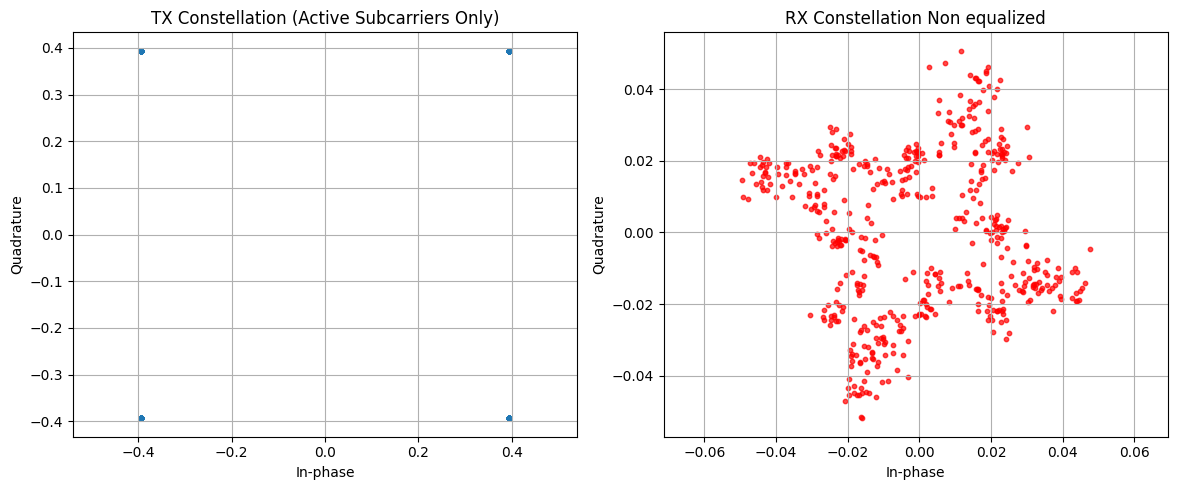

In [131]:
# --- Step 3: Convert to Frequency Domain and Apply FFT Shift ---
active_indices = np.concatenate([np.arange(1, 261), np.arange(764, 1024)])
# Compute the FFT-shifted indices for plotting the shifted spectrum
active_indices_shifted = (active_indices + N//2) % N


[rx_shifted,tx_shifted]=frequency_shifting(rxtd_time_synced,txtd, N)


# Select only active subcarriers for TX and RX
tx_active = tx_shifted[active_indices_shifted]
rx_active = rx_shifted[:,:,active_indices_shifted]  # Example: frame 0, antenna 0


# --- Plotting Only Active Subcarriers ---

plt.figure(figsize=(12, 5))

# TX constellation (active only)
plt.subplot(1, 2, 1)
plt.scatter(np.real(tx_active), np.imag(tx_active), s=10, alpha=0.7)
plt.title('TX Constellation (Active Subcarriers Only)')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.axis('equal')

# RX constellation (active only)
num_frame=0
plt.subplot(1, 2, 2)
plt.scatter(np.real(rx_active[num_frame,0,:]), np.imag(rx_active[num_frame,0,:]), s=10, color='red', alpha=0.7)
plt.title('RX Constellation Non equalized')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.axis('equal')

plt.tight_layout()
plt.show()

## Channel Estimation  : Kernel Regression vs Linear Interpolation

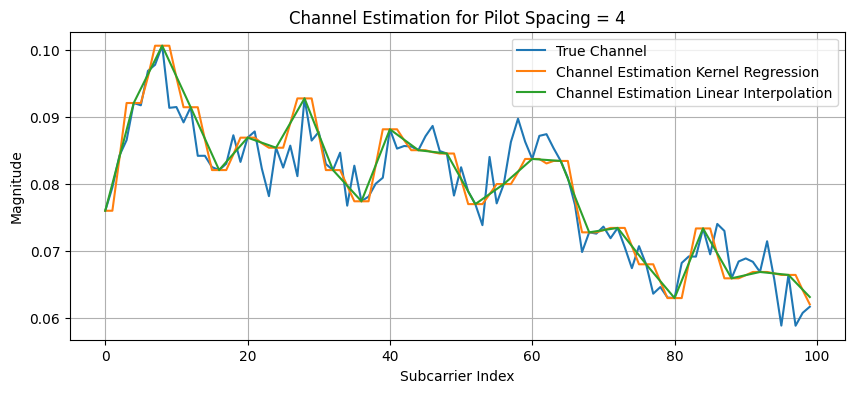

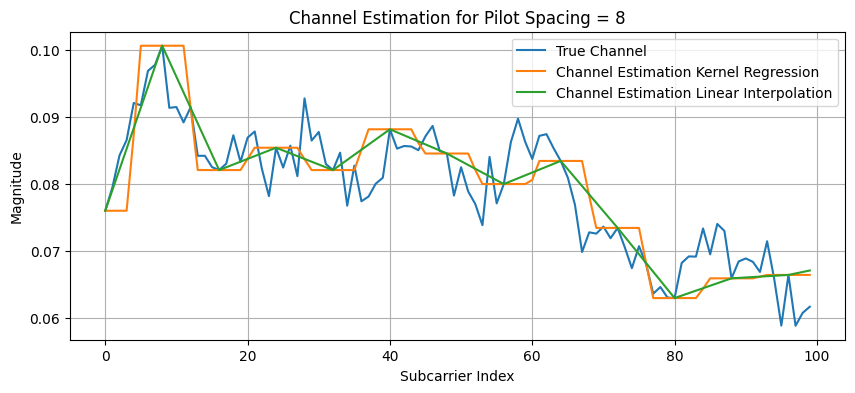

In [124]:
from scipy.interpolate import interp1d
def kernel_regression_channel_estimation(pilot_indices, H_pilot, all_indices, sigma=3):
    """
    Estimate the channel at all_indices using kernel regression from pilot_indices and H_pilot.
    Args:
        pilot_indices: 1D array of pilot positions (indices in active_indices_shifted)
        H_pilot: 1D array of complex channel estimates at pilot positions
        all_indices: 1D array of all subcarrier indices (e.g., np.arange(num_active_subcarriers))
        sigma: kernel width (in subcarrier units)
    Returns:
        H_est: 1D array of estimated channel at all_indices
    """
    # Compute the distance matrix between all subcarriers and pilot positions
    diff = all_indices[:, None] - pilot_indices[None, :]
    weights = np.exp(-0.5 * (diff / sigma) ** 2)
    numerator = np.sum(weights * H_pilot[None, :], axis=1)
    denominator = np.sum(weights, axis=1) + 1e-12  # Avoid division by zero
    H_est = numerator / denominator
    return H_est


pilot_spacing =4
pilot_indices = np.arange(0, len(active_indices_shifted), pilot_spacing)
all_indices = np.arange(len(rx_active[frame_idx,ant_idx,:]))
ant_idx=0
for frame_idx in range(256):
        H_pilot = rx_active[frame_idx,ant_idx,pilot_indices] / tx_active[pilot_indices]
        H_est_kernel_regression = kernel_regression_channel_estimation(pilot_indices, H_pilot, all_indices, sigma=0.5) # Sigma is tuned( we choose the best one)
for frame_idx in range(256):
        mag_interp = interp1d(pilot_indices, np.abs(H_pilot), kind='linear', fill_value="extrapolate")
        phase_unwrapped = np.unwrap(np.angle(H_pilot))
        phase_interp = interp1d(pilot_indices, phase_unwrapped, kind='linear', fill_value="extrapolate")
        H_est_linear_interpolation = mag_interp(all_indices) * np.exp(1j * phase_interp(all_indices))


x=np.arange(0,100)
plt.figure(figsize=(10,4))
plt.plot(x,abs(rx_active[frame_idx,ant_idx,0:100]/abs(tx_active[0:100])))
plt.plot(x,abs(H_est_kernel_regression[0:100]))
plt.plot(x,abs(H_est_linear_interpolation[0:100]))
plt.title('Channel Estimation for Pilot Spacing = 4')
plt.xlabel('Subcarrier Index')
plt.ylabel('Magnitude')
plt.legend(['True Channel ','Channel Estimation Kernel Regression','Channel Estimation Linear Interpolation'])
plt.grid()

pilot_spacing =8
pilot_indices = np.arange(0, len(active_indices_shifted), pilot_spacing)
all_indices = np.arange(len(rx_active[frame_idx,ant_idx,:]))
ant_idx=0
for frame_idx in range(256):
        H_pilot = rx_active[frame_idx,ant_idx,pilot_indices] / tx_active[pilot_indices]
        H_est_kernel_regression = kernel_regression_channel_estimation(pilot_indices, H_pilot, all_indices, sigma=1) # Sigma is tuned( we choose the best one)
for frame_idx in range(256):
        mag_interp = interp1d(pilot_indices, np.abs(H_pilot), kind='linear', fill_value="extrapolate")
        phase_unwrapped = np.unwrap(np.angle(H_pilot))
        phase_interp = interp1d(pilot_indices, phase_unwrapped, kind='linear', fill_value="extrapolate")
        H_est_linear_interpolation = mag_interp(all_indices) * np.exp(1j * phase_interp(all_indices))

x=np.arange(0,100)
plt.figure(figsize=(10,4))
plt.plot(x,abs(rx_active[frame_idx,ant_idx,0:100]/abs(tx_active[0:100])))
plt.plot(x,abs(H_est_kernel_regression[0:100]))
plt.plot(x,abs(H_est_linear_interpolation[0:100]))
plt.title('Channel Estimation for Pilot Spacing = 8')
plt.xlabel('Subcarrier Index')
plt.ylabel('Magnitude')
plt.legend(['True Channel ','Channel Estimation Kernel Regression','Channel Estimation Linear Interpolation'])
plt.grid()

We will use the kernel regression estimation to equalize our channel

0.0019230769230769232


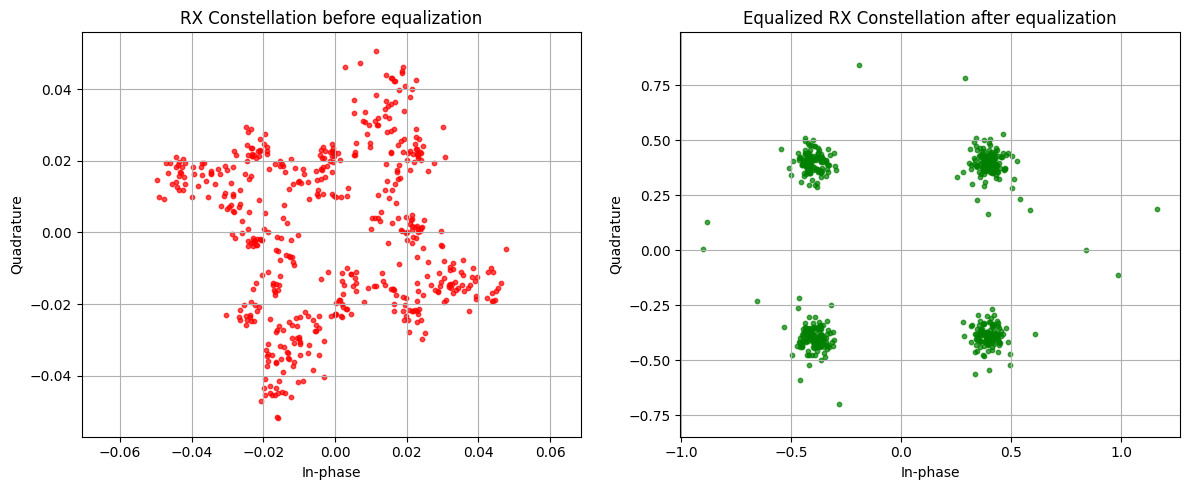

In [158]:
#epsilon = 1e-12
#H_est = rx_active / (tx_active)
from scipy.interpolate import interp1d
def qam_demod(symbols):
    # symbols: array of complex, returns bits in shape (len(symbols), 2)
    bits = np.zeros((len(symbols), 2), dtype=int)
    bits[:,0] = (np.real(symbols) > 0).astype(int)
    bits[:,1] = (np.imag(symbols) > 0).astype(int)
    return bits
def kernel_regression_channel_estimation(pilot_indices, H_pilot, all_indices, sigma=3):
    """
    Estimate the channel at all_indices using kernel regression from pilot_indices and H_pilot.
    Args:
        pilot_indices: 1D array of pilot positions (indices in active_indices_shifted)
        H_pilot: 1D array of complex channel estimates at pilot positions
        all_indices: 1D array of all subcarrier indices (e.g., np.arange(num_active_subcarriers))
        sigma: kernel width (in subcarrier units)
    Returns:
        H_est: 1D array of estimated channel at all_indices
    """
    # Compute the distance matrix between all subcarriers and pilot positions
    diff = all_indices[:, None] - pilot_indices[None, :]
    weights = np.exp(-0.5 * (diff / sigma) ** 2)
    numerator = np.sum(weights * H_pilot[None, :], axis=1)
    denominator = np.sum(weights, axis=1) + 1e-12  # Avoid division by zero
    H_est = numerator / denominator
    return H_est

pilot_spacing =4
pilot_indices = np.arange(0, len(active_indices_shifted), pilot_spacing)

# 2. Estimate channel at pilot subcarriers

rx_equalized=np.zeros(rx_active.shape,dtype = 'complex')
all_indices = np.arange(len(rx_active[frame_idx,ant_idx,:]))
ant_idx=0
for frame_idx in range(256):
        H_pilot = rx_active[frame_idx,ant_idx,pilot_indices] / tx_active[pilot_indices]
        H_est = kernel_regression_channel_estimation(pilot_indices, H_pilot, all_indices, sigma=6)
        rx_equalized[frame_idx, ant_idx, :] = rx_active[frame_idx, ant_idx, :] / (H_est + 1e-12)



plt.figure(figsize=(12, 5))
num_frame=0

tx_bits = qam_demod(tx_active)
rx_bits = qam_demod(rx_equalized[num_frame, 0, :])
ber_per_frame = np.sum(tx_bits != rx_bits) / (2*len(tx_bits))
print(ber_per_frame)

plt.subplot(1, 2, 1)
plt.scatter(np.real(rx_active[num_frame,0,:]), np.imag(rx_active[num_frame,0,:]), s=10, color='red', alpha=0.7)
plt.title('RX Constellation before equalization')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.axis('equal')


plt.subplot(1, 2, 2)
plt.scatter(np.real(rx_equalized[num_frame,0,:]), np.imag(rx_equalized[num_frame,0,:]), s=10, color='green', alpha=0.7)
plt.xlim(-0.5,0.5)
plt.ylim(-0.5, 0.5)
plt.title('Equalized RX Constellation after equalization')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

0.0019230769230769232


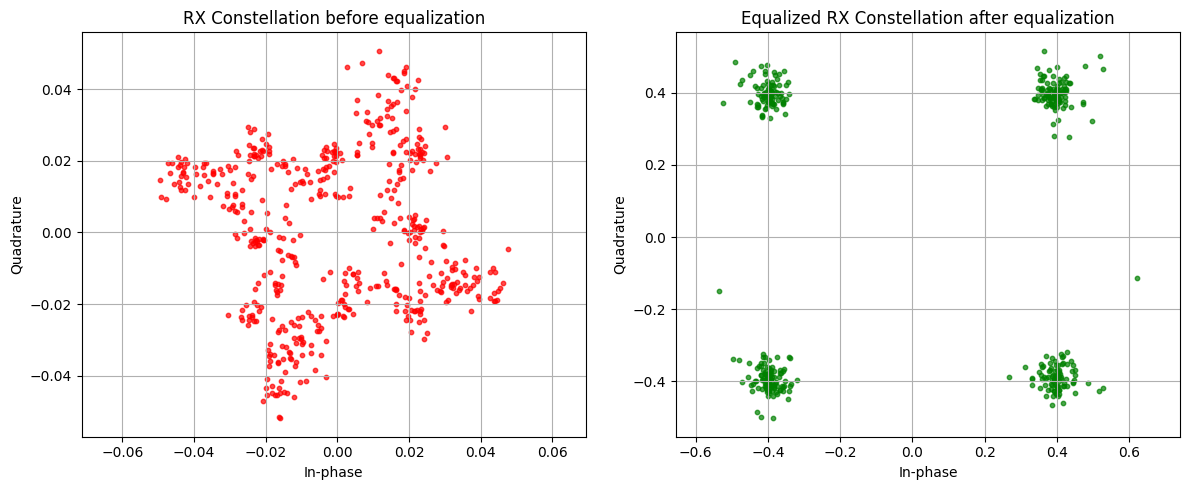

In [138]:
#epsilon = 1e-12
#H_est = rx_active / (tx_active)
from scipy.interpolate import interp1d
def qam_demod(symbols):
    # symbols: array of complex, returns bits in shape (len(symbols), 2)
    bits = np.zeros((len(symbols), 2), dtype=int)
    bits[:,0] = (np.real(symbols) > 0).astype(int)
    bits[:,1] = (np.imag(symbols) > 0).astype(int)
    return bits
def kernel_regression_channel_estimation(pilot_indices, H_pilot, all_indices, sigma=3):
    """
    Estimate the channel at all_indices using kernel regression from pilot_indices and H_pilot.
    Args:
        pilot_indices: 1D array of pilot positions (indices in active_indices_shifted)
        H_pilot: 1D array of complex channel estimates at pilot positions
        all_indices: 1D array of all subcarrier indices (e.g., np.arange(num_active_subcarriers))
        sigma: kernel width (in subcarrier units)
    Returns:
        H_est: 1D array of estimated channel at all_indices
    """
    # Compute the distance matrix between all subcarriers and pilot positions
    diff = all_indices[:, None] - pilot_indices[None, :]
    weights = np.exp(-0.5 * (diff / sigma) ** 2)
    numerator = np.sum(weights * H_pilot[None, :], axis=1)
    denominator = np.sum(weights, axis=1) + 1e-12  # Avoid division by zero
    H_est = numerator / denominator
    return H_est

pilot_spacing =4
pilot_indices = np.arange(0, len(active_indices_shifted), pilot_spacing)

# 2. Estimate channel at pilot subcarriers

rx_equalized=np.zeros(rx_active.shape,dtype = 'complex')
all_indices = np.arange(len(rx_active[frame_idx,ant_idx,:]))
ant_idx=0
for frame_idx in range(256):
        H_pilot = rx_active[frame_idx,ant_idx,pilot_indices] / tx_active[pilot_indices]
        mag_interp = interp1d(pilot_indices, np.abs(H_pilot), kind='linear', fill_value="extrapolate")
        phase_unwrapped = np.unwrap(np.angle(H_pilot))
        phase_interp = interp1d(pilot_indices, phase_unwrapped, kind='linear', fill_value="extrapolate")
        all_indices = np.arange(len(rx_active[frame_idx,ant_idx,:]))
        H_est = mag_interp(all_indices) * np.exp(1j * phase_interp(all_indices))
        rx_equalized[frame_idx,ant_idx,:] = rx_active[frame_idx,ant_idx,:] / (H_est + 1e-12)



plt.figure(figsize=(12, 5))
num_frame=0

tx_bits = qam_demod(tx_active)
rx_bits = qam_demod(rx_equalized[num_frame, 0, :])
ber_per_frame = np.sum(tx_bits != rx_bits) / (2*len(tx_bits))
print(ber_per_frame)

plt.subplot(1, 2, 1)
plt.scatter(np.real(rx_active[num_frame,0,:]), np.imag(rx_active[num_frame,0,:]), s=10, color='red', alpha=0.7)
plt.title('RX Constellation before equalization')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.axis('equal')


plt.subplot(1, 2, 2)
plt.scatter(np.real(rx_equalized[num_frame,0,:]), np.imag(rx_equalized[num_frame,0,:]), s=10, color='green', alpha=0.7)
plt.xlim(-0.5,0.5)
plt.ylim(-0.5, 0.5)
plt.title('Equalized RX Constellation after equalization')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

## Plotting Average BER vs Number of pilot spacing

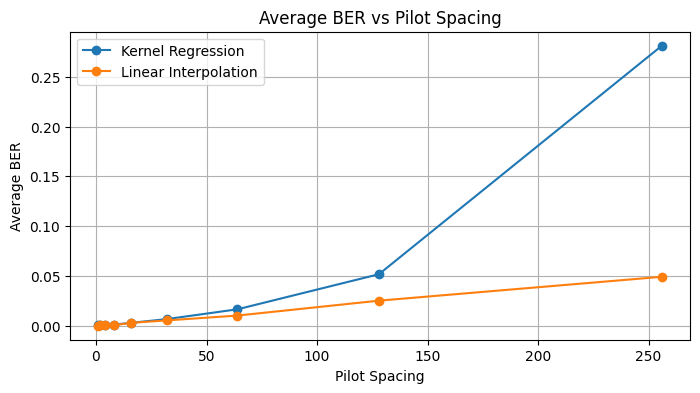

In [167]:
from scipy.interpolate import CubicSpline
def qam_demod(symbols):
    # symbols: array of complex, returns bits in shape (len(symbols), 2)
    bits = np.zeros((len(symbols), 2), dtype=int)
    bits[:,0] = (np.real(symbols) > 0).astype(int)
    bits[:,1] = (np.imag(symbols) > 0).astype(int)
    return bits

# Reference TX bits
ant=0
ant_idx=0
tx_bits = qam_demod(tx_active)

nb_pilots = np.arange(1, 500, 10)
ofdm_size = 520

# 1. Find all pilot spacings that evenly divide the OFDM size
def find_divisors(n):
    return [i for i in range(1, n+1) if n % i == 0 and i!=n]

pilot_spacing_vector= [1,2,4,8,16,32,64,128,256]  # [1]
ber_per_frame=np.zeros(256)
avg_ber_linear=np.zeros(len(pilot_spacing_vector))
avg_ber_kernel=np.zeros(len(pilot_spacing_vector))

for i in range(len(pilot_spacing_vector)):
  pilot_spacing = pilot_spacing_vector[i]
  pilot_indices = np.arange(0, len(active_indices_shifted), pilot_spacing)
  rx_equalized=np.zeros(rx_active.shape,dtype = 'complex')
  ber_per_frame=np.zeros(256)
  for frame_idx in range(256):
          H_pilot = rx_active[frame_idx,ant_idx,pilot_indices] / tx_active[pilot_indices]
          mag_interp = interp1d(pilot_indices, np.abs(H_pilot), kind='linear', fill_value="extrapolate")
          phase_unwrapped = np.unwrap(np.angle(H_pilot))
          phase_interp = interp1d(pilot_indices, phase_unwrapped, kind='linear', fill_value="extrapolate")
          all_indices = np.arange(len(rx_active[frame_idx,ant_idx,:]))
          H_est = mag_interp(all_indices) * np.exp(1j * phase_interp(all_indices))
          rx_equalized[frame_idx,ant_idx,:] = rx_active[frame_idx,ant_idx,:] / (H_est + 1e-12)
          rx_bits = qam_demod(rx_equalized[frame_idx, ant, :])
          ber_per_frame[frame_idx] = np.sum(tx_bits != rx_bits) / (2*len(tx_bits))

  avg_ber_linear[i] = np.mean(ber_per_frame)
  for frame_idx in range(256):
          H_pilot = rx_active[frame_idx,ant_idx,pilot_indices] / tx_active[pilot_indices]
          H_est = kernel_regression_channel_estimation(pilot_indices, H_pilot, all_indices, sigma=6)
          rx_equalized[frame_idx, ant_idx, :] = rx_active[frame_idx, ant_idx, :] / (H_est + 1e-12)
          rx_bits = qam_demod(rx_equalized[frame_idx, ant, :])
          ber_per_frame[frame_idx] = np.sum(tx_bits != rx_bits) / (2*len(tx_bits))

  avg_ber_kernel[i] = np.mean(ber_per_frame)

plt.figure(figsize=(8,4))
#plt.plot(number_pilots, avg_ber[::-1], marker='o', linestyle='-')

plt.plot(pilot_spacing_vector, avg_ber_kernel, marker='o', linestyle='-')
plt.plot(pilot_spacing_vector, avg_ber_linear, marker='o', linestyle='-')
plt.title('Average BER vs Pilot Spacing')
plt.xlabel('Pilot Spacing')
plt.ylabel('Average BER')
plt.legend(['Kernel Regression','Linear Interpolation'])
plt.grid()

Linear interpolation outperforms kernel regression as we increase the pilot spacing (sigma=6 is the best value we tuned)

# Introducing static CFO  : Exemple case: 40 ppm

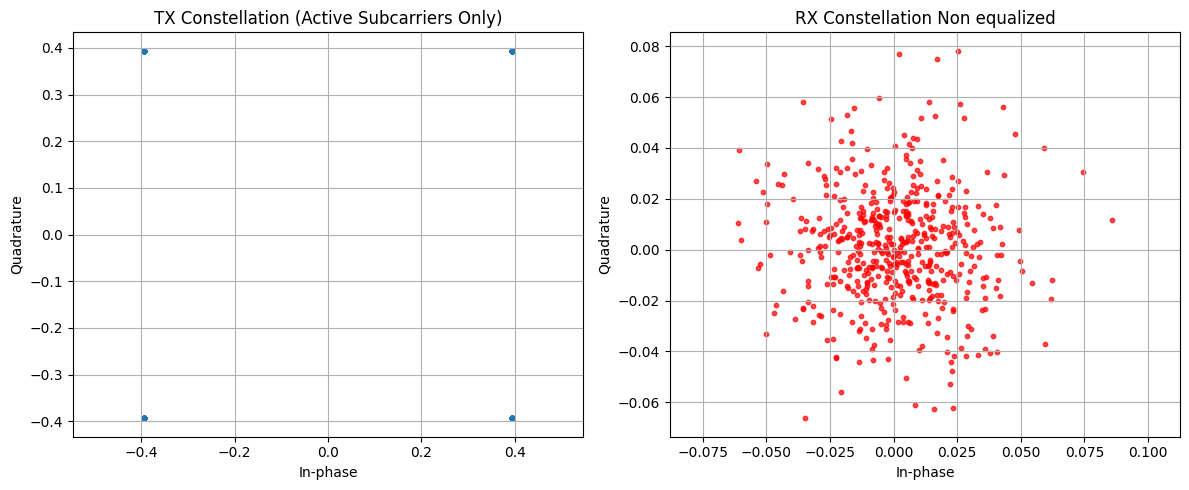

In [192]:
data = np.load('10.0GHz_40ppm.npz')
txtd= np.array(data['txtd'])
rxtd=np.array(data['rxtd_10.0'])
ref_signal_time = txtd[0, 0, :]
# Synchronization :
rxtd_time_synced = synchronize_frames_with_tx_ref(rxtd, ref_signal_time)
[rx_shifted,tx_shifted]=frequency_shifting(rxtd_time_synced,txtd, N)


# Select only active subcarriers for TX and RX
tx_active = tx_shifted[active_indices_shifted]
rx_active = rx_shifted[:,:,active_indices_shifted]  # Example: frame 0, antenna 0


# --- Plotting Only Active Subcarriers ---

plt.figure(figsize=(12, 5))

# TX constellation (active only)
plt.subplot(1, 2, 1)
plt.scatter(np.real(tx_active), np.imag(tx_active), s=10, alpha=0.7)
plt.title('TX Constellation (Active Subcarriers Only)')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.axis('equal')

# RX constellation (active only)
num_frame=0
plt.subplot(1, 2, 2)
plt.scatter(np.real(rx_active[num_frame,0,:]), np.imag(rx_active[num_frame,0,:]), s=10, color='red', alpha=0.7)
plt.title('RX Constellation Non equalized')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.axis('equal')

plt.tight_layout()
plt.show()

0.17115384615384616


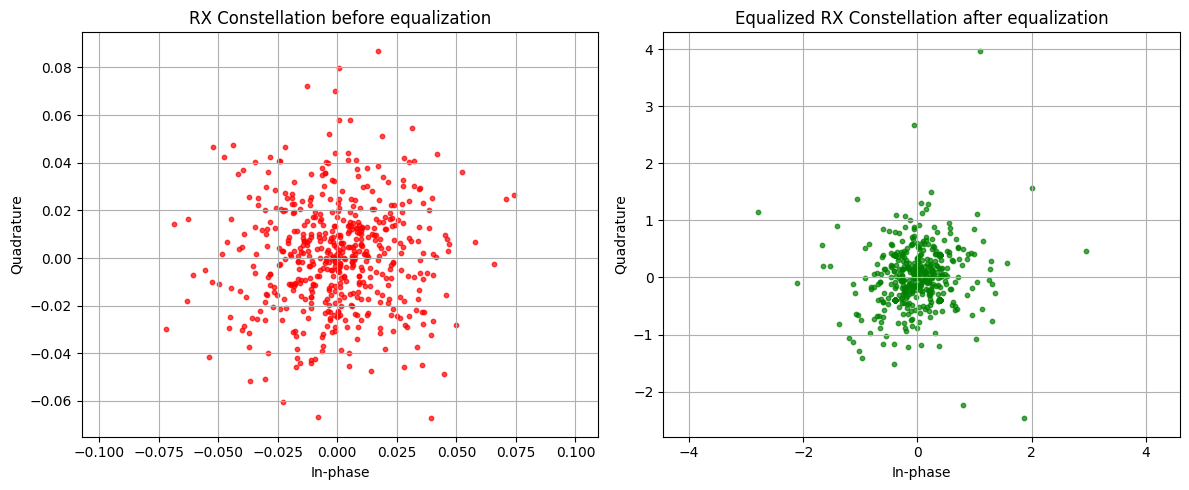

In [200]:
pilot_spacing =4
pilot_indices = np.arange(0, len(active_indices_shifted), pilot_spacing)

# 2. Estimate channel at pilot subcarriers

rx_equalized=np.zeros(rx_active.shape,dtype = 'complex')
all_indices = np.arange(len(rx_active[frame_idx,ant_idx,:]))
ant_idx=0
for frame_idx in range(256):
        H_pilot = rx_active[frame_idx,ant_idx,pilot_indices] / tx_active[pilot_indices]
        mag_interp = interp1d(pilot_indices, np.abs(H_pilot), kind='linear', fill_value="extrapolate")
        phase_unwrapped = np.unwrap(np.angle(H_pilot))
        phase_interp = interp1d(pilot_indices, phase_unwrapped, kind='linear', fill_value="extrapolate")
        all_indices = np.arange(len(rx_active[frame_idx,ant_idx,:]))
        H_est = mag_interp(all_indices) * np.exp(1j * phase_interp(all_indices))
        rx_equalized[frame_idx,ant_idx,:] = rx_active[frame_idx,ant_idx,:] / (H_est + 1e-12)



plt.figure(figsize=(12, 5))
num_frame=100

tx_bits = qam_demod(tx_active)
rx_bits = qam_demod(rx_equalized[num_frame, 0, :])
ber_per_frame = np.sum(tx_bits != rx_bits) / (2*len(tx_bits))
print(ber_per_frame)

plt.subplot(1, 2, 1)
plt.scatter(np.real(rx_active[num_frame,0,:]), np.imag(rx_active[num_frame,0,:]), s=10, color='red', alpha=0.7)
plt.title('RX Constellation before equalization')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.axis('equal')


plt.subplot(1, 2, 2)
plt.scatter(np.real(rx_equalized[num_frame,0,:]), np.imag(rx_equalized[num_frame,0,:]), s=10, color='green', alpha=0.7)
plt.xlim(-0.5,0.5)
plt.ylim(-0.5, 0.5)
plt.title('Equalized RX Constellation after equalization')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

We can see the effect of the introduced CFO, even after equalization, the equalized signal constellation is very noisy and the bit error rate is high

Let:

$N$: Number of subcarriers (OFDM symbol length)

$s[n]$: Transmitted time-domain OFDM symbol (after IFFT)

$\epsilon$: Normalized CFO (in subcarrier spacings)

$r[n]$: Received time-domain sample

The recieved sample  with CFO:

$r[n] = s[n] \cdot e^{j 2\pi \epsilon n / N}$

Suppose two consecutive OFDM symbols are identical:

$s_1[n] = s_2[n] = s[n]$

Their received samples are:

$r_1[n] = s[n] \cdot e^{j 2\pi \epsilon n / N}$

$r_2[n] = s[n] \cdot e^{j 2\pi \epsilon (n+N) / N} = s[n] \cdot e^{j 2\pi \epsilon n / N} \cdot e^{j 2\pi \epsilon}$

Correlation of Consecutive Symbols:

$C = \sum_{n=0}^{N-1} r_2[n] \cdot r_1^*[n]$

Substitute the expressions:

$C = \sum_{n=0}^{N-1} \left[ s[n] \cdot e^{j 2\pi \epsilon n / N} \cdot e^{j 2\pi \epsilon} \right] \cdot \left[ s^*[n] \cdot e^{-j 2\pi \epsilon n / N} \right]$

$= \sum_{n=0}^{N-1} |s[n]|^2 \cdot e^{j 2\pi \epsilon}$

$= e^{j 2\pi \epsilon} \sum_{n=0}^{N-1} |s[n]|^2$

The sum is real and positive (energy of the symbol), so the phase of $C$ is $2\pi \epsilon$.

Extracting the CFO:

$\epsilon = \frac{1}{2\pi} \arg(C)$

This gives the normalized CFO (in subcarrier spacings).


Reference : P. K. Nishad and P. Singh, "Carrier frequency offset estimation in OFDM systems," 2013 IEEE Conference on Information & Communication Technologies, Thuckalay, India, 2013, pp. 885-889, doi: 10.1109/CICT.2013.6558220.

In [204]:
def estimate_cfo(rxtd_synced):
    """
    Estimates normalized CFO using phase differences between consecutive frames.
    Assumes identical transmitted frames and stable channel.
    """
    num_frames, num_ants, N = rxtd_synced.shape
    ant_idx=0
    # Inter-frame estimation
    phases = []
    for frame_idx in range(1, num_frames):
        prev = rxtd_synced[frame_idx-1, ant_idx, :]
        curr = rxtd_synced[frame_idx, ant_idx, :]
        corr = np.sum(curr * np.conj(prev))
        phases.append(np.angle(corr))

    phases = np.unwrap(phases)
    xi_frame = np.median(phases) / (2 * np.pi)
    return xi_frame

# System parameters
fc = 10e9  # 10 GHz carrier frequency
fs = 983.04e6  # Sampling frequency
N = 1024  # FFT size

# 1. CFO Estimation
print("Estimating CFO...")
cfo_estimate = estimate_cfo(rxtd_time_synced)
actual_cfo_hz = cfo_estimate * (fs / N)  # Convert to Hz
cfo_ppm = (actual_cfo_hz / fc) * 1e6

print(f"Normalized CFO: {-cfo_estimate:.6f}")
print(f"CFO in Hz: {-actual_cfo_hz/1e3:.2f} kHz")
print(f"CFO in ppm: {-cfo_ppm:.2f} ppm")

Estimating CFO...
Normalized CFO: 0.418592
CFO in Hz: 401.85 kHz
CFO in ppm: 40.18 ppm


The CFO estimated is 40.18 ppm matches with the introduced CFO (40 ppm). Our estimation is accurate

# CFO Correction

In [215]:
def correct_cfo(rxtd_synced, cfo_estimate):
    """Applies CFO correction to time-domain signals"""
    N = rxtd_synced.shape[-1]
    n = np.arange(N)
    correction = np.exp(-1j * 2 * np.pi * cfo_estimate * n / N)
    rxtd_corrected = rxtd_synced * correction[np.newaxis, np.newaxis, :]
    return rxtd_corrected


# 2. CFO Correction


rxtd_corrected = correct_cfo(rxtd_time_synced, cfo_estimate)
rx_freq = np.fft.fftshift(np.fft.fft(rxtd, axis=-1)/np.sqrt(N), axes=-1)
rx_freq_corrected = np.fft.fftshift(np.fft.fft(rxtd_corrected, axis=-1)/np.sqrt(N), axes=-1)

rx_active=rx_freq[:,:,active_indices_shifted]
rx_active_corrected=rx_freq_corrected[:,:,active_indices_shifted]

## Equalization

0.0009615384615384616


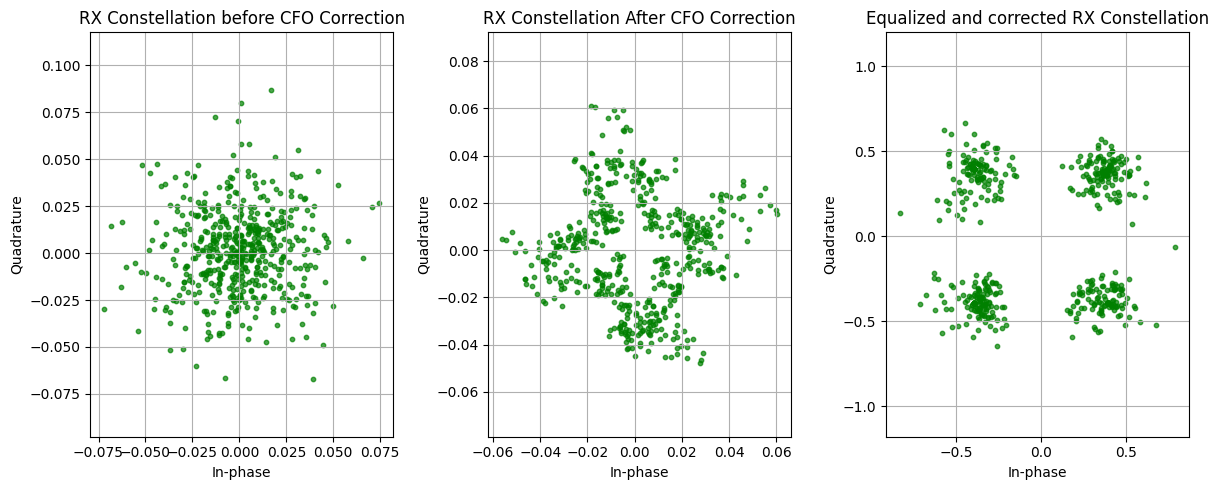

In [ ]:
def equalize(rx_active,tx_active,pilot_spacing,active_indices_shifted):
  pilot_indices = np.arange(0, len(active_indices_shifted), pilot_spacing)
  rx_equalized=np.zeros(rx_active.shape,dtype = 'complex')
  ant_idx=0
  for frame_idx in range(256):
              H_pilot = rx_active[frame_idx,ant_idx,pilot_indices] / tx_active[pilot_indices]
              # 3. Interpolate channel estimate to all active subcarriers
              mag_interp = interp1d(pilot_indices, np.abs(H_pilot), kind='linear', fill_value="extrapolate")
              phase_unwrapped = np.unwrap(np.angle(H_pilot))
              phase_interp = interp1d(pilot_indices, phase_unwrapped, kind='linear', fill_value="extrapolate")
              all_indices = np.arange(len(rx_active[frame_idx,ant_idx,:]))
              H_est = mag_interp(all_indices) * np.exp(1j * phase_interp(all_indices))
              rx_equalized[frame_idx,ant_idx,:] = rx_active[frame_idx,ant_idx,:] / (H_est + 1e-12)
  return(rx_equalized)


pilot_spacing=8
rx_equalized_corrected=equalize(rx_active_corrected,tx_active,pilot_spacing,active_indices_shifted)


# Plotting

plt.figure(figsize=(12, 5))
num_frame= 100
tx_bits = qam_demod(tx_active)
rx_bits = qam_demod(rx_equalized_corrected[num_frame, 0, :])
ber_per_frame = np.sum(tx_bits != rx_bits) / (2*len(tx_bits))

print(ber_per_frame)

plt.subplot(1, 3, 1)
plt.scatter(np.real(rx_active[num_frame,0,:]), np.imag(rx_active[num_frame,0,:]), s=10, color='green', alpha=0.7)
plt.title('RX Constellation before CFO Correction')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.axis('equal')

plt.subplot(1, 3, 2)
plt.scatter(np.real(rx_active_corrected[num_frame,0,:]), np.imag(rx_active_corrected[num_frame,0,:]), s=10, color='green', alpha=0.7)
plt.title('RX Constellation After CFO Correction')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.axis('equal')


plt.subplot(1, 3, 3)

plt.scatter(np.real(rx_equalized_corrected[num_frame,0,:]), np.imag(rx_equalized_corrected[num_frame,0,:]), s=10, color='green', alpha=0.7)
plt.xlim(-0.5,0.5)
plt.ylim(-0.5, 0.5)
plt.title('Equalized and corrected RX Constellation')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

So by applying the CFO estimation and correction we managed to mitigate the CFO effect and with equalization we reconstructed the transmitted constellation with a small bit error rate

## Estimated CFO vs ground Truth CFO

In [209]:
# System parameters
fc = 10e9  # 10 GHz carrier frequency
fs = 983.04e6  # Sampling frequency
N = 1024  # FFT size

# Active indices
active_indices = np.concatenate([np.arange(1, 261), np.arange(764, 1024)])
active_indices_shifted = (active_indices + N//2) % N

# CFO values to test
cfo_values = [-40, -20, 0, 20, 40,60]

def estimate_cfo(rxtd_synced):
    num_frames, num_ants, N = rxtd_synced.shape
    ant_idx=0
    phases = []
    for frame_idx in range(1, num_frames):
        prev = rxtd_synced[frame_idx-1, ant_idx, :]
        curr = rxtd_synced[frame_idx, ant_idx, :]
        corr = np.sum(curr * np.conj(prev))
        phases.append(np.angle(corr))
    phases = np.unwrap(phases)
    xi_frame = np.median(phases) / (2 * np.pi)
    return xi_frame

results = {}

for cfo in cfo_values:
    filename = f'10.0GHz_{cfo}ppm.npz'
    try:
        data = np.load(filename)
        txtd = np.array(data['txtd'])
        # Find the key for received data that matches 'rxtd_10.0'
        rxtd_key = [key for key in data.files if key.startswith('rxtd_10.0')][0]
        rxtd = np.array(data[rxtd_key])
        ref_signal_time = txtd[0, 0, :]

        # Assume you have these functions defined elsewhere
        rxtd_time_synced = synchronize_frames_with_tx_ref(rxtd, ref_signal_time)
        rx_shifted, tx_shifted = frequency_shifting(rxtd_time_synced, txtd, N)

        # Estimate CFO
        cfo_estimate = -estimate_cfo(rxtd_time_synced)
        actual_cfo_hz = cfo_estimate * (fs / N)
        cfo_ppm_measured = (actual_cfo_hz / fc) * 1e6
        results[cfo] = {
            'normalized_cfo': cfo_estimate,
            'actual_cfo_hz': actual_cfo_hz,
            'cfo_ppm_measured': cfo_ppm_measured
        }

        print(f"CFO {cfo} ppm: Measured normalized CFO = {cfo_estimate:.6f}, Measured CFO = {cfo_ppm_measured:.2f} ppm")
    except Exception as e:
        results[cfo] = {'error': str(e)}
        print(f"CFO {cfo} ppm: Error - {e}")



CFO -40 ppm: Measured normalized CFO = -0.414896, Measured CFO = -39.83 ppm
CFO -20 ppm: Measured normalized CFO = -0.206428, Measured CFO = -19.82 ppm
CFO 0 ppm: Measured normalized CFO = 0.001166, Measured CFO = 0.11 ppm
CFO 20 ppm: Measured normalized CFO = 0.210175, Measured CFO = 20.18 ppm
CFO 40 ppm: Measured normalized CFO = 0.418592, Measured CFO = 40.18 ppm


The estimated CFO matches perfectly with the ground truth CFO which confirms the accuracy of the estimation algorithm